### MMDetection 설치

In [43]:
!pip install mmcv-full
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

     |████████████████████████████████| 307kB 13.6MB/s 
     |████████████████████████████████| 194kB 18.7MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.5-cp37-cp37m-linux_x86_64.whl size=27342380 sha256=52a80f4aa6741e9fdc286050266a20c8f447035bfd7b93cdb3172348ff3babb3
  Stored in directory: /root/.cache/pip/wheels/06/1b/49/7a6ca2a423aa7ad9cbd2caf83f10e0ee09aa06e109994dcc0b
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 18028, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 18028 (delta 45), reused 62 (delta 19), pack-reused 17904
Receiving objects: 100% (18028/18028), 21.39 MiB | 25.50 MiB/s, done.
Resolving deltas: 100% (12531/12531), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
wr

In [2]:
# 아래를 수행하기 전에 kernel을 restart 해야 함. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### tiny coco dataset download

In [ ]:
!git clone https://github.com/chongruo/tiny-coco.git

Cloning into 'tiny-coco'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 0), reused 29 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


### Open Image Dataset에서 일부 클래스만 추출하여 변환하기

In [1]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 2.68 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [7]:
!cd OID*; pip install -r requirements.txt

     |████████████████████████████████| 3.6MB 15.0MB/s 
     |████████████████████████████████| 7.6MB 50.7MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
     |████████████████████████████████| 552kB 45.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: botocore 1.20.84 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1


In [12]:
!cd OID*;python main.py downloader -y --classes Fish Shark Shellfish --type_csv train --multiclasses 1 --limit 300


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Fish', 'Shark', 'Shellfish'] together.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Automatic download.
...145%, 0 MB, 63010 KB/s, 0 seconds passed
[DOWNLOAD] | Fil

In [20]:
!ls -lia; cd OID*;ls -lia;cd OID ; ls -lia;cd Dataset; ls -lia;cd train; ls -lia

total 247012
3934382 drwxr-xr-x 1 root root      4096 May 30 11:55 .
3037549 drwxr-xr-x 1 root root      4096 May 30 10:53 ..
4589475 drwxr-xr-x 2 root root      4096 May 30 11:55 annotations
4589474 -rw-r--r-- 1 root root 252907541 Jul 10  2018 annotations_trainval2017.zip
4589415 drwxr-xr-x 3 root root      4096 May 30 11:54 coco-manager
1180687 drwxr-xr-x 4 root root      4096 May  6 13:43 .config
4587522 drwxr-xr-x 6 root root      4096 May 30 11:31 OIDv4_ToolKit
3934383 drwxr-xr-x 1 root root      4096 May  6 13:44 sample_data
total 208
4587522 drwxr-xr-x 6 root root   4096 May 30 11:31 .
3934382 drwxr-xr-x 1 root root   4096 May 30 11:55 ..
4587567 -rw-r--r-- 1 root root     26 May 30 11:25 classes.txt
4587523 drwxr-xr-x 8 root root   4096 May 30 11:25 .git
4587550 -rw-r--r-- 1 root root 120020 May 30 11:25 .gitignore
4587568 drwxr-xr-x 2 root root   4096 May 30 11:25 images
4587565 -rw-r--r-- 1 root root  35147 May 30 11:25 LICENSE
4587572 -rw-r--r-- 1 root root    912 May 30 11

### Open Image Dataset을 Pascal VOC 포맷으로 변환하는 패키지 다운로드

In [21]:
!wget https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/oid_to_pascal_voc_xml.py

--2021-05-30 12:12:40--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/oid_to_pascal_voc_xml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6506 (6.4K) [text/plain]
Saving to: ‘oid_to_pascal_voc_xml.py’

oid_to_pascal_voc_x 100%[===================>]   6.35K  --.-KB/s    in 0s      

2021-05-30 12:12:40 (68.3 MB/s) - ‘oid_to_pascal_voc_xml.py’ saved [6506/6506]



In [22]:
!cp oid_to*.py /content/OIDv4_ToolKit

In [26]:
!cd ./OIDv4_ToolKit; python oid_to_pascal_voc_xml.py

Currently in Subdirectory: train

Creating PASCAL VOC XML Files for Class: Fish_Shark_Shellfish
100% 900/900 [00:10<00:00, 83.76it/s]


In [27]:
!mv /content/OIDv4_ToolKit/OID/Dataset/train/Fish_Shark_Shellfish /content/OIDv4_ToolKit/OID/Dataset/train/ballnfish

In [29]:
!cd /content/OIDv4_ToolKit/OID/Dataset/train/ballnfish; mkdir images; mkdir annotations
!cp /content/OIDv4_ToolKit/OID/Dataset/train/ballnfish/*.xml /content/OIDv4_ToolKit/OID/Dataset/train/ballnfish/annotations
!cp /content/OIDv4_ToolKit/OID/Dataset/train/ballnfish/*.jpg /content/OIDv4_ToolKit/OID/Dataset/train/ballnfish/images

mkdir: cannot create directory ‘images’: File exists


### PASCAL VOC형태의 BCCD Dataset를 MS-COCO 형태로 변경

In [30]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 12.73 MiB/s, done.
Resolving deltas: 100% (378/378), done.


### VOC를 COCO로 변환하는 package적용하기

In [31]:
!git clone https://github.com/yukkyo/voc2coco.git

Cloning into 'voc2coco'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 420 (delta 3), reused 8 (delta 3), pack-reused 409
Receiving objects: 100% (420/420), 213.31 KiB | 7.90 MiB/s, done.
Resolving deltas: 100% (379/379), done.


In [35]:
import os

# colab 버전은 아래 명령어로 ballnfish_classes.txt 를 수정합니다. 
with open('/content/BCCD_Dataset/BCCD/labels.txt', "w") as f:
    f.write("WBC\n")
    f.write("RBC\n")
    f.write("Platelets\n")

!cat /content/BCCD_Dataset/BCCD/labels.txt

WBC
RBC
Platelets


In [38]:
%cd voc2coco
!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/train.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/val.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/test.json \
--ext xml

[Errno 2] No such file or directory: 'voc2coco'
/content/voc2coco
Start converting !
100% 205/205 [00:00<00:00, 5047.15it/s]
Start converting !
100% 87/87 [00:00<00:00, 5641.17it/s]
Start converting !
100% 72/72 [00:00<00:00, 5316.91it/s]


In [39]:
!cat /content/BCCD_Dataset/BCCD/train.json

{"images": [{"file_name": "BloodImage_00001.jpg", "height": 480, "width": 640, "id": "BloodImage_00001"}, {"file_name": "BloodImage_00003.jpg", "height": 480, "width": 640, "id": "BloodImage_00003"}, {"file_name": "BloodImage_00004.jpg", "height": 480, "width": 640, "id": "BloodImage_00004"}, {"file_name": "BloodImage_00005.jpg", "height": 480, "width": 640, "id": "BloodImage_00005"}, {"file_name": "BloodImage_00006.jpg", "height": 480, "width": 640, "id": "BloodImage_00006"}, {"file_name": "BloodImage_00008.jpg", "height": 480, "width": 640, "id": "BloodImage_00008"}, {"file_name": "BloodImage_00009.jpg", "height": 480, "width": 640, "id": "BloodImage_00009"}, {"file_name": "BloodImage_00010.jpg", "height": 480, "width": 640, "id": "BloodImage_00010"}, {"file_name": "BloodImage_00012.jpg", "height": 480, "width": 640, "id": "BloodImage_00012"}, {"file_name": "BloodImage_00013.jpg", "height": 480, "width": 640, "id": "BloodImage_00013"}, {"file_name": "BloodImage_00020.jpg", "height": 

In [40]:
!sudo apt-get install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 0s (2,846 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /

In [42]:
!jq . /content/BCCD_Dataset/BCCD/train.json > output.json


### Cigarette butt dataset 다운로드
* Coco와 동일한 json 포맷의 Cigarrette butt Dataset을 다운로드하고 /content 밑에 압축 해제

In [ ]:
!wget https://github.com/chulminkw/CNN_PG/releases/download/1.2/cig_butts.zip
!unzip cig_butts.zip

In [ ]:
# json 파일을 보다 편하게 보기 위해서 jq 설치. 
!sudo apt-get install jq

In [ ]:
!head -100 cig_butts/train/coco_annotations.json 

{"info": {"description": "ImmersiveLimit Cigarette Butt Dataset", "url": "http://www.immersivelimit.com", "version": "0.1", "year": 2018, "contributor": "Adam Kelly", "date_created": "2018/07/27"}, "licenses": [{"url": "http://www.immersivelimit.com/noncommercial-educational-license-agreement", "id": 0, "name": "ImmersiveLimit.com Non-Commercial, Educational License Agreement"}], "images": [{"license": 0, "file_name": "00000000.jpg", "width": 512, "height": 512, "id": 0}, {"license": 0, "file_name": "00000001.jpg", "width": 512, "height": 512, "id": 1}, {"license": 0, "file_name": "00000002.jpg", "width": 512, "height": 512, "id": 2}, {"license": 0, "file_name": "00000003.jpg", "width": 512, "height": 512, "id": 3}, {"license": 0, "file_name": "00000004.jpg", "width": 512, "height": 512, "id": 4}, {"license": 0, "file_name": "00000005.jpg", "width": 512, "height": 512, "id": 5}, {"license": 0, "file_name": "00000006.jpg", "width": 512, "height": 512, "id": 6}, {"license": 0, "file_name

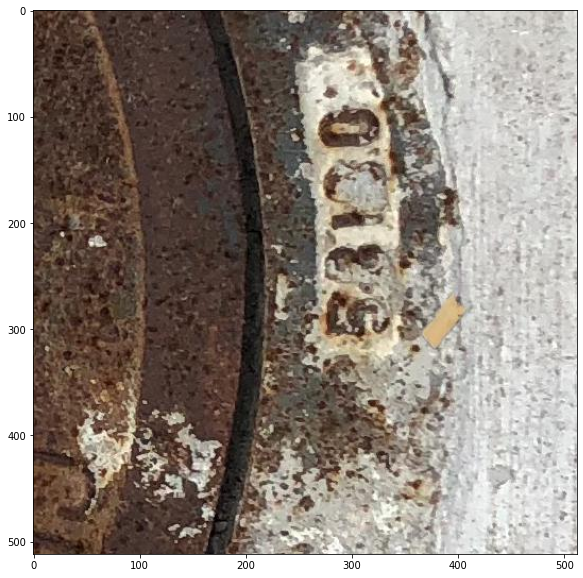

In [ ]:
import mmcv
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/cig_butts/train/images/00000002.jpg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

In [15]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets')

In [7]:
import os.path as osp

# 디버깅 용도로 CustomDataset을 흉내낸 클래스 생성. 
class BCCDDataset_imsi(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets')

   # 생성자 함수 생성. 
  def __init__(self, data_root, ann_file, img_prefix):
      self.data_root = data_root
      self.ann_file = osp.join(data_root, ann_file)
      self.img_prefix = osp.join(data_root, img_prefix)
      
      self.data_infos = self.load_annotations(self.ann_file)
       def get_ann_info(self, idx):
        """Get COCO annotation by index.
        Args:
            idx (int): Index of data.
        Returns:
            dict: Annotation info of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return self._parse_ann_info(self.data_infos[idx], ann_info)

In [8]:
train_ds = BCCDDataset_imsi(data_root='/content/BCCD_Dataset/BCCD', ann_file='train.json', img_prefix='JPEGImages')
#print(train_ds.data_infos[:10])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[{'file_name': 'BloodImage_00001.jpg', 'height': 480, 'width': 640, 'id': 'BloodImage_00001', 'filename': 'BloodImage_00001.jpg'}, {'file_name': 'BloodImage_00003.jpg', 'height': 480, 'width': 640, 'id': 'BloodImage_00003', 'filename': 'BloodImage_00003.jpg'}, {'file_name': 'BloodImage_00004.jpg', 'height': 480, 'width': 640, 'id': 'BloodImage_00004', 'filename': 'BloodImage_00004.jpg'}, {'file_name': 'BloodImage_00005.jpg', 'height': 480, 'width': 640, 'id': 'BloodImage_00005', 'filename': 'BloodImage_00005.jpg'}, {'file_name': 'BloodImage_00006.jpg', 'height': 480, 'width': 640, 'id': 'BloodImage_00006', 'filename': 'BloodImage_00006.jpg'}, {'file_name': 'BloodImage_00008.jpg', 'height': 480, 'width': 640, 'id': 'BloodImage_00008', 'filename': 'BloodImage_00008.jpg'}, {'file_name': 'BloodImage_00009.jpg', 'height': 480, 'width': 640, 'id': 'BloodImage_00009', 'filename': 'BloodImage_00009.jpg'}, {'file

In [ ]:
train_ds = PetDataset_imsi(data_root='/content/data', ann_file='train.txt', img_prefix='images')
print(train_ds.data_infos[:10])

In [16]:
config_file = '/content/voc2coco/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/voc2coco/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [14]:
!pwd

/content


In [17]:
!cd /content/voc2coco/mmdetection; mkdir checkpoints
!wget -O /content/voc2coco/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-05-30 13:28:26--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/voc2coco/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/voc2coco/m 100%[===================>] 159.54M  6.52MB/s    in 22s     

2021-05-30 13:28:50 (7.20 MB/s) - ‘/content/voc2coco/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [ ]:
!ls -lia /content/mmdetection/checkpoints

total 173708
3170332 drwxr-xr-x  2 root root      4096 May 21 02:48 .
3161995 drwxr-xr-x 19 root root      4096 May 21 02:48 ..
3163350 -rw-r--r--  1 root root 177867103 Aug 31  2020 mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


In [18]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Los

In [44]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = '/content/BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '/content/voc2coco/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [45]:
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        pretrained='torchvision://resnet50'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_we

In [46]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [47]:
# datasets[0].__dict__ 로 모든 self variables의 key와 value값을 볼 수 있음. 
datasets[0].__dict__.keys()

dict_keys(['ann_file', 'data_root', 'img_prefix', 'seg_prefix', 'proposal_file', 'test_mode', 'filter_empty_gt', 'CLASSES', 'coco', 'cat_ids', 'cat2label', 'img_ids', 'data_infos', 'proposals', 'flag', 'pipeline'])

In [49]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

/usr/local/lib/python3.7/dist-packages/mmdet-2.12.0-py3.7.egg/mmdet/models/backbones/resnet.py:400: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


('WBC', 'RBC', 'Platelets')


In [50]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets, cfg, distributed=False, validate=True)

2021-05-30 13:47:03,800 - mmdet - INFO - load checkpoint from /content/voc2coco/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2021-05-30 13:47:03,801 - mmdet - INFO - Use load_from_local loader


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2021-05-30 13:47:03,934 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([12]).
2021-05-30 13:47:03,943 - mmdet - INFO - Start running, host: root@a841e549468e, work_dir: /content/tutorial_exps
2021-05-30 13:47:03,944 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs
2021-05-30 13:47:09,500 - mmdet - INFO - E

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 87/87, 12.9 task/s, elapsed: 7s, ETA:     0s

2021-05-30 13:54:27,130 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-05-30 13:54:27,910 - mmdet - INFO - Saving checkpoint at 12 epochs


DONE (t=0.69s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.717
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

2021-05-30 13:54:28,730 - mmdet - INFO - Epoch(val) [12][87]	bbox_mAP: 0.6260, bbox_mAP_50: 0.9010, bbox_mAP_75: 0.7170, bbox_mAP_s: 0.1540, bbox_mAP_m: 0.4940, bbox_mAP_l: 0.7300, bbox_mAP_copypaste: 0.626 0.901 0.717 0.154 0.494 0.730


/usr/local/lib/python3.7/dist-packages/mmdet-2.12.0-py3.7.egg/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


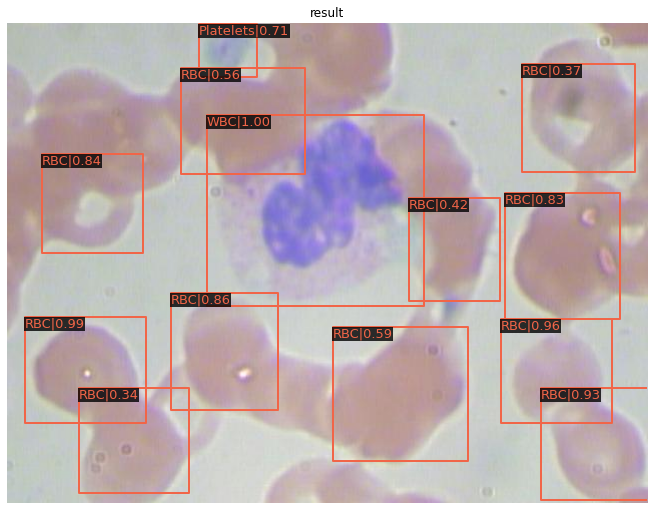

In [53]:
import cv2
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = cv2.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [54]:
model.__dict__

{'CLASSES': ('WBC', 'RBC', 'Platelets'),
 '_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_is_init': False,
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('backbone', ResNet(
                 (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                 (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                 (relu): ReLU(inplace=True)
                 (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                 (layer1): ResLayer(
                   (0): Bottleneck(
                     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                     (conv2): Conv2d(64, 64, kernel

In [62]:
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.datasets import (build_dataloader, build_dataset)

dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
    
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader, True, './content', 0.3)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
[                                                  ] 0/72, elapsed: 0s, ETA:

KeyError: ignored

In [108]:
import os.path as osp
import pickle
import shutil
import tempfile
import time

import mmcv
import torch
import torch.distributed as dist
from mmcv.image import tensor2imgs
from mmcv.runner import get_dist_info

from mmdet.core import encode_mask_results

def single_gpu_test1(model,
                    data_loader,
                    show=False,
                    out_dir=None,
                    show_score_thr=0.3):
    #print('before eval')
    model.eval()
    #print('after eval')
    results = []
    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))
    #print('#### before loader')
    for i, data in enumerate(data_loader):
        #print('#### torch no_grad')
        with torch.no_grad():
            #print('#### before result')
            result = model(return_loss=False, rescale=True, **data)
        #print('##### result')
        batch_size = len(result)
        #print('##### result batch_size:', batch_size)
        if show or out_dir:
            if batch_size == 1 and isinstance(data['img'][0], torch.Tensor):
                img_tensor = data['img'][0]
            else:
                img_tensor = data['img'][0]
            img_metas = data['img_metas'][0].data[0]
            #print('#### img_tensor shape:', img_tensor.shape)
            #print('### is_tensor:', torch.is_tensor(img_tensor))
            imgs = tensor2imgs(img_tensor, **img_metas[0]['img_norm_cfg'])
            assert len(imgs) == len(img_metas)

            for i, (img, img_meta) in enumerate(zip(imgs, img_metas)):
                h, w, _ = img_meta['img_shape']
                img_show = img[:h, :w, :]

                ori_h, ori_w = img_meta['ori_shape'][:-1]
                img_show = mmcv.imresize(img_show, (ori_w, ori_h))

                if out_dir:
                    out_file = osp.join(out_dir, img_meta['ori_filename'])
                else:
                    out_file = None
                    model.module.show_result(
                    img_show,
                    result[i],
                    show=show,
                    out_file=out_file,
                    score_thr=show_score_thr)

        # encode mask results
        if isinstance(result[0], tuple):
            result = [(bbox_results, encode_mask_results(mask_results))
                      for bbox_results, mask_results in result]
        results.extend(result)
        for _ in range(batch_size):
            prog_bar.update()
    return results

In [110]:
import torch
dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
    
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test1(model, data_loader, True, '/content/tutorial_exps', 0.3)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[                                                  ] 0/87, elapsed: 0s, ETA:##### result batch_size: 2
[                                  ] 2/87, 4.4 task/s, elapsed: 0s, ETA:    19s##### result batch_size: 2
[>                                 ] 4/87, 5.8 task/s, elapsed: 1s, ETA:    14s##### result batch_size: 2
[>>                                ] 6/87, 6.5 task/s, elapsed: 1s, ETA:    13s##### result batch_size: 2
[>>>                               ] 8/87, 6.9 task/s, elapsed: 1s, ETA:    11s##### result batch_size: 2
[>>>                              ] 10/87, 7.3 task/s, elapsed: 1s, ETA:    11s##### result batch_size: 2
[>>>>                             ] 12/87, 7.5 task/s, elapsed: 2s, ETA:    10s##### result batch_size: 2
[>>>>>                            ] 14/87, 7.6 task/s, elapsed: 2s, ETA:    10s##### result batch_size: 2
[>>>>>>                           ] 16/87, 7.7 task/s, elapsed: 2s, ETA:

In [119]:
print('결과 outputs type:', type(outputs))
print('evalution 된 파일의 갯수:', len(outputs))
print('첫번째 evalutation 결과의 type:', type(outputs[0]))
print('첫번째 evaluation 결과의 CLASS 갯수:', len(outputs[0]))
print('첫번째 evaluation 결과의 CLASS ID 0의 type과 shape', type(outputs[0][0]), outputs[0][0].shape)

결과 outputs type: <class 'list'>
evalution 된 파일의 갯수: 87
첫번째 evalutation 결과의 type: <class 'list'>
첫번째 evaluation 결과의 CLASS 갯수: 3
첫번째 evaluation 결과의 CLASS ID 0의 type과 shape <class 'numpy.ndarray'> (16, 5)


In [122]:
eval_kwargs = cfg.get('evaluation', {}).copy()
# hard-code way to remove EvalHook args
for key in ['interval', 'tmpdir', 'start', 'gpu_collect', 'save_best', 'rule']:
    eval_kwargs.pop(key, None)
eval_kwargs

{'by_epoch': True, 'metric': 'bbox'}

In [125]:
eval_kwargs = cfg.get('evaluation', {}).copy()
# hard-code way to remove EvalHook args
for key in ['interval', 'tmpdir', 'start', 'gpu_collect', 'save_best', 'rule']:
    eval_kwargs.pop(key, None)

metric = dataset.evaluate(outputs, metric='bbox')
print(metric)


Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.15s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.892
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 

In [111]:
!ls /content/tutorial_exps

epoch_12.pth  latest.pth  None.log.json


In [97]:
imgs = next(iter(data_loader))

In [90]:
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.datasets import (build_dataloader, build_dataset)

dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
if cfg.get('custom_imports', None):
        from mmcv.utils import import_modules_from_strings
        import_modules_from_strings(**cfg['custom_imports'])
# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True    
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader, True, './content', 0.3)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[                                                  ] 0/87, elapsed: 0s, ETA:

AssertionError: ignored

In [102]:
imgs['img'][0].data[0]

tensor([[[0.8961, 0.8961, 0.8961,  ..., 0.0000, 0.0000, 0.0000],
         [0.8961, 0.8961, 0.8961,  ..., 0.0000, 0.0000, 0.0000],
         [0.8961, 0.8961, 0.8961,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.4440, 1.4269, 1.3927,  ..., 0.0000, 0.0000, 0.0000],
         [1.4440, 1.4269, 1.3927,  ..., 0.0000, 0.0000, 0.0000],
         [1.4612, 1.4269, 1.3927,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6604, 0.6604, 0.6604,  ..., 0.0000, 0.0000, 0.0000],
         [0.6604, 0.6604, 0.6604,  ..., 0.0000, 0.0000, 0.0000],
         [0.6604, 0.6604, 0.6604,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.5707, 1.5532, 1.5182,  ..., 0.0000, 0.0000, 0.0000],
         [1.5707, 1.5532, 1.5182,  ..., 0.0000, 0.0000, 0.0000],
         [1.5882, 1.5532, 1.5182,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6879, 0.6879, 0.6879,  ..., 0.0000, 0.0000, 0.0000],
         [0.6879, 0.6879, 0.6879,  ..., 0.0000, 0.0000, 0.0000],
         [0.6879, 0.6879, 0.6879,  ..., 0.0000, 0.0000, 0.

In [61]:
%cd /content/voc2coco/mmdetection
!python tools/test.py \
--config /content/mmdetection/configs/DetectoRS/My_DetectoRS_resnet101_from_x.py \
--checkpoint /content/tutorial_exps/epoch_12.pth \
--eval 'bbox' \
--show-dir /content \
#--out "/content/drive/My Drive/Global_Wheat_Detection/mmdet-resnet101/result.pkl" 

SyntaxError: ignored